# Regression Project: Predicting Home Prices in Banglore

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

## load the data into a dataframe, and clean the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Bengaluru_House_Data.csv"
df1 = pd.read_csv(path)
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
df1.shape

(13320, 9)

In [ ]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [ ]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [ ]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

drop features that are not required to build our model

In [ ]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis = 'columns')
df2.shape

(13320, 5)

## Data cleaning: handle NA values

In [ ]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [ ]:
df2.shape

(13320, 5)

In [ ]:
df3 =df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [ ]:
df3.shape

(13246, 5)

# Feature Engineering

In [ ]:
# add new feature (integer) for bhk (Bedrooms Hall Kitchen)

df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

df3.bhk.unique() #there are home with 43 bedrooms!! 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [ ]:
# explore total_sqft feature
# convert value in total_sqft feature into float 
def is_float(x):
  try:
      float(x)
  except:
      return False
  return True 

In [ ]:
2+3

5

In [ ]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Most ranges indicate min and max values in the range, but there are values such as 34.46 sq.Meter or 2145Perch. For such cases, I could convert the value in Sq.Meter to Sq ft , or perch to sqft using unit conversion. However, here I will just drop such corner cases to keep things simple.

In [ ]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:  
        return float(x)
    except:
        return None
        

In [ ]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


In [ ]:
df4.loc[30] #for this row, it shows that total_sqft as 2475 is an average of the range 2100-2850.

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [ ]:
(2100+2850)/2

2475.0

Add new feature called price per square feet

In [ ]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [ ]:
df5.to_csv("bhp.csv", index= False)

Check the number of locations, and how many rows are available in the dataset. Location is a categorical variable.

In [ ]:
#check the number of locations

print(len(df5.location.unique()))
print(df5.location.unique())


241
['Electronic City Phase II' 'Chikka Tirupathi' 'Uttarahalli'
 'Lingadheeranahalli' 'Kothanur' 'Whitefield' 'Old Airport Road'
 'Rajaji Nagar' 'Marathahalli' 'other' '7th Phase JP Nagar' 'Gottigere'
 'Sarjapur' 'Mysore Road' 'Bisuvanahalli' 'Raja Rajeshwari Nagar'
 'Kengeri' 'Binny Pete' 'Thanisandra' 'Bellandur' 'Electronic City'
 'Ramagondanahalli' 'Yelahanka' 'Hebbal' 'Kasturi Nagar' 'Kanakpura Road'
 'Electronics City Phase 1' 'Kundalahalli' 'Chikkalasandra'
 'Murugeshpalya' 'Sarjapur  Road' 'HSR Layout' 'Doddathoguru' 'KR Puram'
 'Bhoganhalli' 'Lakshminarayana Pura' 'Begur Road' 'Varthur'
 'Bommanahalli' 'Gunjur' 'Devarachikkanahalli' 'Hegde Nagar'
 'Haralur Road' 'Hennur Road' 'Kothannur' 'Kalena Agrahara'
 'Kaval Byrasandra' 'ISRO Layout' 'Garudachar Palya' 'EPIP Zone'
 'Dasanapura' 'Kasavanhalli' 'Sanjay nagar' 'Domlur'
 'Sarjapura - Attibele Road' 'Yeshwanthpur' 'Chandapura' 'Nagarbhavi'
 'Devanahalli' 'Ramamurthy Nagar' 'Malleshwaram' 'Akshaya Nagar'
 'Shampura' 'Kadugodi'

There are 1,300 locations, which is a big number. To handle the text data, we convert it into dummy columns using one hot encoding. 
We need to apply dimensionality reduction technique to reduce the number of locations.

In [ ]:
# strip any extra spaces from the location. (leading spaces/ spaces at the end)

df5.location =df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending= False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [ ]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield               533
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           264
Thanisandra              235
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Kannur                     1
whitefiled                 1
Name: location, Length: 1287, dtype: int64

In [ ]:
len(location_stats[location_stats <= 10])

1047

In [ ]:
location_stats.values.sum()

13200

In [ ]:
len(location_stats[location_stats>10])

240

In [ ]:
len(location_stats)

1287

## Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way, number of categories can be reduced by huge amount. Later on when we do one-hot-encoding, it will help us with having fewer dummy columns.

In [ ]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
Sadashiva Nagar          10
Naganathapura            10
Basapura                 10
Nagadevanahalli          10
Kalkere                  10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Kannur                    1
whitefiled                1
Name: location, Length: 1047, dtype: int64

In [ ]:
len(df5.location.unique())

1287

In [ ]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x )

In [ ]:
len(df5.location.unique()) #only have 241 for one-hot-encoding

241

In [ ]:
df5.head(100) #good! some locations have turned to "other"

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
97,Sarjapura - Attibele Road,3 BHK,1330.0,2.0,48.00,3,3609.022556
98,other,2 BHK,1200.0,2.0,65.00,2,5416.666667
99,other,3 Bedroom,1200.0,3.0,90.00,3,7500.000000
100,Yeshwanthpur,3 BHK,2502.0,3.0,138.00,3,5515.587530


## Outlier Removal Using Business Logic

In real-estate, normally square ft per bedroom is 300 (2hk apartment is minimum 600 sqft.) If an aprtment with 2 bhk is 400 sqft, it seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum threshold per bhk to be 300 sqft. 

In [ ]:
df5[(df5.total_sqft/df5.bhk) <300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely. 

In [ ]:
df5.shape

(13200, 7)

In [ ]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

## Outlier Removal Using Standard Deviation and Mean

In [ ]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation. 

In [ ]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

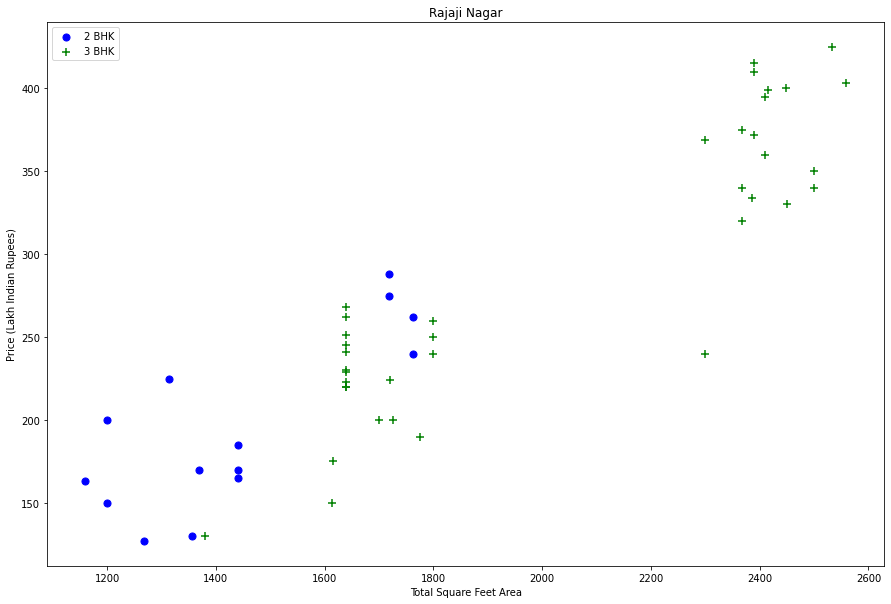

In [ ]:
#let's check if for a given location how does the 2 BHK and 3 BHK property prices look like
# Scatter Plot for the location "Rajaji Najar"

def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

We should also remove properties where for same location, the price of 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, ie. 
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    }}

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment. 

In [ ]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

Plot the same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties.

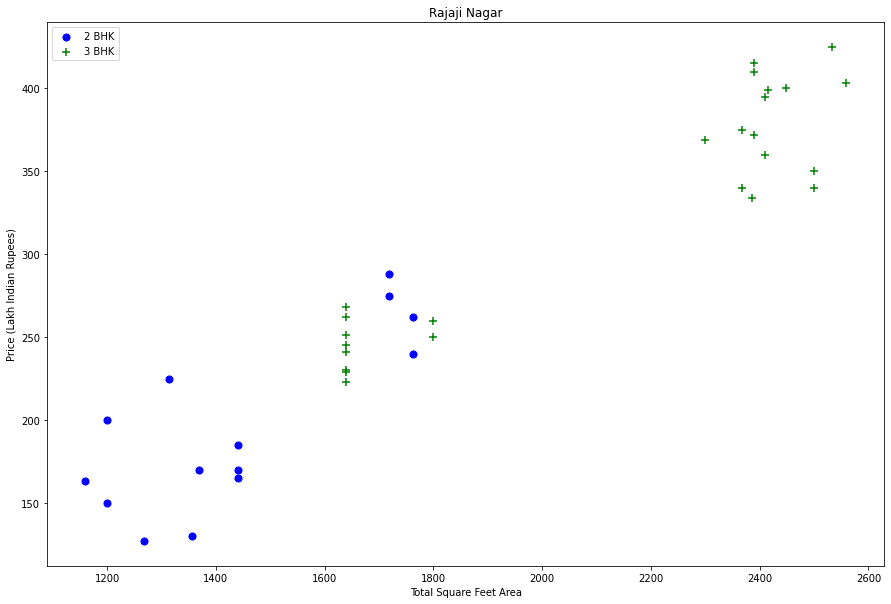

In [ ]:
plot_scatter_chart(df8, "Rajaji Nagar")

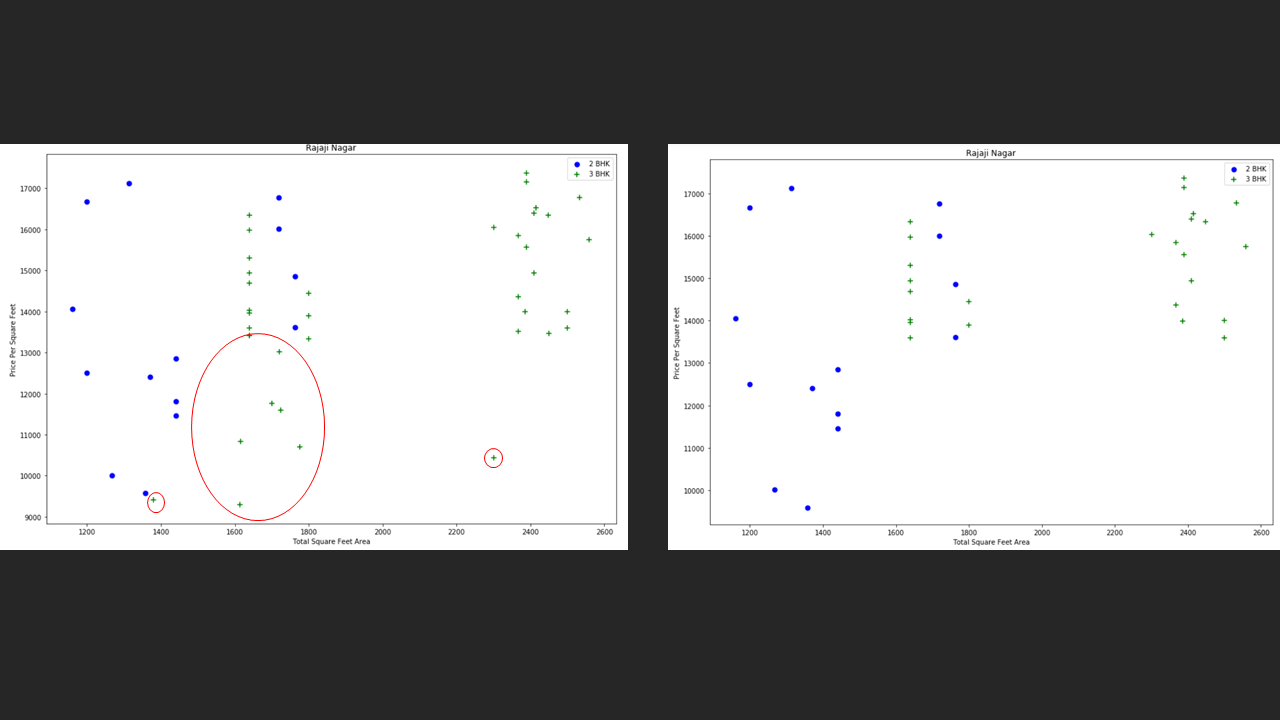

As shown above, if we compare before and after oulier removal, green data points in the circled zone in the picture are gone. Majority 3 bedroom apartments are now priced higher than 2 bedroom apartments. 

Text(0, 0.5, 'Count')

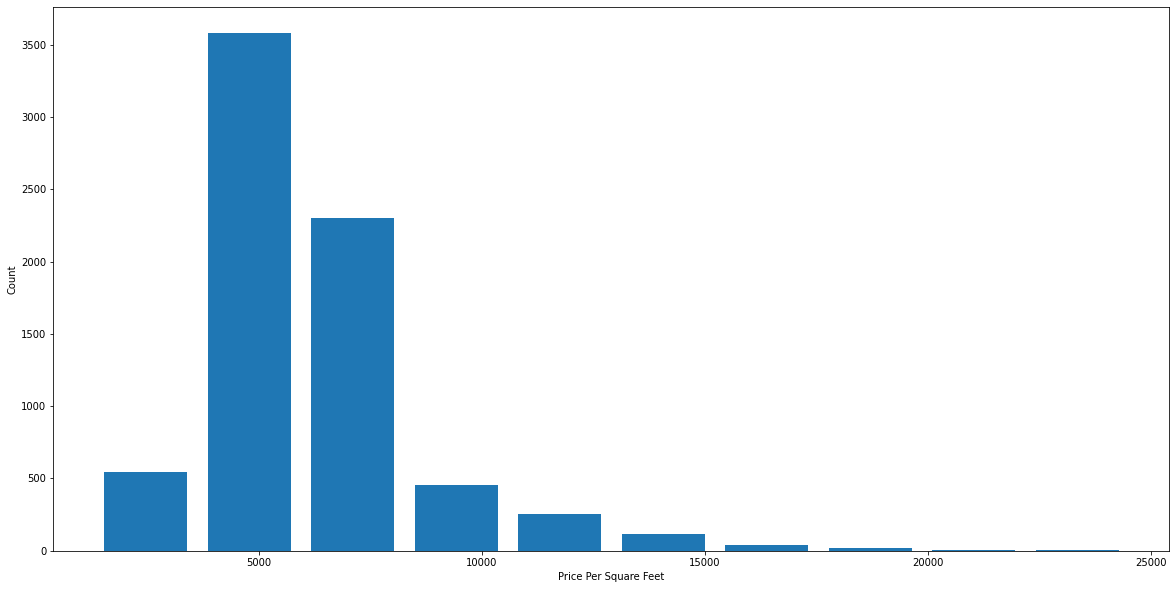

In [ ]:
# histogram
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

## Outlier Removal using Bathrooms Feature

In [ ]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

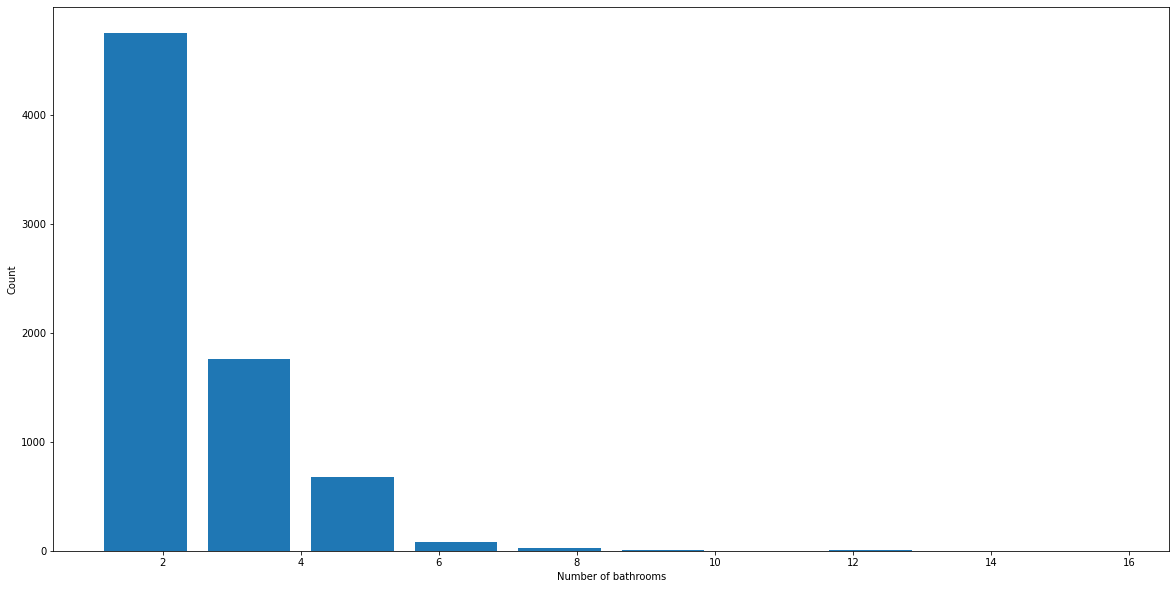

In [ ]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [ ]:
df8[df8.bath >10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


It is unusal to have two more bathrooms than number of bedrooms in a home.

In [ ]:
df8[df8.bath > df8.bhk]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
10,1st Phase JP Nagar,3 BHK,2065.0,4.0,210.0,3,10169.491525
16,1st Phase JP Nagar,1 BHK,840.0,2.0,50.0,1,5952.380952
36,2nd Stage Nagarbhavi,6 Bedroom,3000.0,8.0,451.0,6,15033.333333
37,2nd Stage Nagarbhavi,6 Bedroom,2400.0,8.0,450.0,6,18750.000000
48,5th Phase JP Nagar,2 BHK,1150.0,3.0,52.5,2,4565.217391
...,...,...,...,...,...,...,...
10146,other,4 Bedroom,3100.0,5.0,425.0,4,13709.677419
10175,other,2 BHK,600.0,3.0,72.0,2,12000.000000
10203,other,4 BHK,6652.0,6.0,660.0,4,9921.828022
10210,other,4 Bedroom,6688.0,6.0,700.0,4,10466.507177


In [ ]:
df8[df8.bath > df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


For example, if you have 4-bedroom home and even if you have bathrooms in all 4 rooms plus one guest bathroom, you will have total bath = total bed +1 max. Anything above that is an outlier or a data error.

In [ ]:
df9 = df8[df8.bath < df8.bhk+2]
df9.shape

(7239, 7)

In [ ]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [ ]:
df10 = df9.drop(['size', 'price_per_sqft'], axis = 'columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


Machine Learning model cannot read text data, so we have to convert this into numeric info via One Hot Encoding (aka dummies). 

## Use One Hot Encoding for Location

In [ ]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#append dummies to original dataframe.
df11 = pd.concat([df10, dummies.drop('other', axis= 'columns')], axis= 'columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df12 = df11.drop('location', axis= 'columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build a prediction model

In [ ]:
df12.shape

(7239, 244)

In [ ]:
X = df12.drop(['price'], axis = 'columns') #price is a dependent variable 
X.head(3) # X is needed for the model training. 

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(7239, 243)

In [ ]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [ ]:
len(y)

7239

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=10) 
#20% is test sample and the remaining 80% is training sample.

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train) #fit method on X_train and y_train
lr_clf.score(X_test, y_test) 

0.8629132245229443

## Use K-Fold Cross Validation to measure accuracy of our Linear Regression Model

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size = 0.2 , random_state =0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose.

## Find best model using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.847796,{'normalize': False}
1,lasso,0.726830,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.715885,"{'criterion': 'mse', 'splitter': 'best'}"


linear regression (with normlize false parameter) gives the best score for my model.

## Test the model for few properties

In [ ]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [ ]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

83.86570258312139

In [ ]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

86.08062284986894

In [ ]:
predict_price('Indira Nagar',1000, 2, 2)

193.31197733179874

In [ ]:
predict_price('Indira Nagar',1000, 3, 3)

195.52689759854633

## Export the tested model to a pickle file

In [ ]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
      pickle.dump(lr_clf, f)

## Export location and column information to a file that will be useful later on in our prediction application

In [ ]:
import json
columns = { 
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
  f.write(json.dumps(columns))